# Logistics Regression 

Ödevde banka veri seti kullanılarak Logistic Regression analizi gerçekleştirildi. Burada bir müşterinin kredi borcunu ödeyip ödemediği tahmin edildi. Sonuç olarak %92.079 accuracy oranı elde edildi.

In [93]:
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, MinMaxScaler, Normalizer, StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

from warnings import filterwarnings
filterwarnings('ignore')

In [94]:
def correlation_df(data, remove_columns=None):
    if(remove_columns is None):
        corr = data.corr()
        corr = corr.where(np.triu(np.ones(corr.shape)).astype(np.bool))
        corr = corr.stack().reset_index()
        new_df = corr[corr["level_0"] != corr["level_1"]]
        new_df.columns = ['feature1','feature2','Corr']
        new_df["Corr"] = abs(new_df["Corr"])
    else:
        data2 = data.drop(remove_columns, axis=1)
        corr = data2.corr()
        corr = corr.where(np.triu(np.ones(corr.shape)).astype(np.bool))
        corr = corr.stack().reset_index()
        new_df = corr[corr["level_0"] != corr["level_1"]]
        new_df.columns = ['feature1','feature2','Corr']
        new_df["Corr"] = abs(new_df["Corr"])
    return new_df

def numeric_categoric_variable(data):
    name_of_col = list(data.columns)
    num_var_list = []
    str_var_list = []
    drop_col=[]

    str_var_list = name_of_col.copy()
    for var in name_of_col:
        # check if column belongs to numeric type
        if (data[var].dtypes not in (np.object, np.str)):
            str_var_list.remove(var)
            num_var_list.append(var)
        # drop the omit column from list
    for var in drop_col:
        if var in str_var_list:
            str_var_list.remove(var)
        if var in num_var_list:
            num_var_list.remove(var)
    print("Numeric Column  :\n", num_var_list,
          "\n\nCategoric Column :\n", str_var_list)
    return num_var_list, str_var_list

def layer1(data_norm, remove_col, threshold):
    corr_col=set()
    data2 = data.drop(remove_col, axis=1)
    corrmat=data2.corr()
    for i in range(len(corrmat.columns)):
        for j in range(i):
            if abs(corrmat.iloc[i,j] > threshold):
                colname=corrmat.columns[i]
                corr_col.add(colname)
    corr_col=list(corr_col)
    layer1_df = data_norm.drop(corr_col, axis=1)
    #layer1_df["labels"] = data_norm["labels"]
    return layer1_df

def layer2(new_df, target, num_feats):
    x = new_df.drop(target, axis=1)
    y = new_df[target]
    cor_list = []
    feature_name = list(x.columns)
    for i in list(x.columns):
        cor = np.corrcoef(x[i],y)[0,1]
        cor_list.append(cor)

    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    cor_feature = x.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    return cor_feature

## Data Importing

In [95]:
data = pd.read_csv("hmelq.csv")
data.head()

,bad,loan,mortdue,value,reason,job,yoj,derog,delinq,clage,ninq,clno,debtinc
0,0,81200,18834.0,108355.0,HomeImp,NaN,28.0,0.0,0.0,139.14,0.0,14.0,34.042
1,0,12600,103960.0,127384.0,DebtCon,NaN,2.0,0.0,0.0,129.02,0.0,25.0,34.479
2,0,18000,46865.0,61266.0,DebtCon,NaN,5.0,0.0,0.0,102.59,2.0,9.0,26.354
3,0,10300,57676.0,71027.0,DebtCon,NaN,19.0,0.0,0.0,157.52,1.0,11.0,33.992
4,0,9400,56508.0,78358.0,DebtCon,NaN,17.0,0.0,0.0,141.93,0.0,11.0,32.327


# 1. Data Explorationn

### 1.1. Descriptive Statistics

In [96]:
desc_df = data.describe().T
null_count = data.isnull().sum()
null_percent = (data.isnull().sum() / data.count())*100
variance = data.var()

desc_df["variance"] =  round(variance,3)
desc_df["null_values"] = round(null_count,3)
desc_df["null__rate"] = round(null_percent,3)
desc_df.T

,bad,loan,mortdue,value,yoj,derog,delinq,clage,ninq,clno,debtinc
count,3576.000000,3.576000e+03,3.262000e+03,3.512000e+03,3264.000000,3149.000000,3225.000000,3397.000000,3273.000000,3443.000000,2809.000000
mean,0.199385,1.852970e+04,7.401391e+04,1.010769e+05,8.832644,0.261670,0.432558,179.832529,1.186373,21.507116,33.831737
std,0.399594,1.126283e+04,4.401683e+04,5.486528e+04,7.568046,0.865178,1.099230,87.066198,1.728723,10.167490,9.061837
min,0.000000,1.100000e+03,2.619000e+03,8.800000e+03,0.000000,0.000000,0.000000,0.490000,0.000000,0.000000,0.720000
25%,0.000000,1.100000e+04,4.670025e+04,6.575300e+04,3.000000,0.000000,0.000000,115.600000,0.000000,15.000000,29.140000
50%,0.000000,1.620000e+04,6.585800e+04,8.918300e+04,7.000000,0.000000,0.000000,173.640000,1.000000,20.000000,34.747000
75%,0.000000,2.310000e+04,9.171700e+04,1.189282e+05,13.000000,0.000000,0.000000,230.710000,2.000000,26.000000,38.940000
max,1.000000,8.990000e+04,3.995500e+05,8.500000e+05,41.000000,10.000000,15.000000,1168.230000,17.000000,71.000000,203.312000
variance,0.160000,1.268514e+08,1.937482e+09,3.010198e+09,57.275000,0.749000,1.208000,7580.523000,2.988000,103.378000,82.117000
null_values,0.000000,0.000000e+00,3.140000e+02,6.400000e+01,312.000000,427.000000,351.000000,179.000000,303.000000,133.000000,767.000000


In [97]:
num, cat = numeric_categoric_variable(data)

Numeric Column  :
 ['bad', 'loan', 'mortdue', 'value', 'yoj', 'derog', 'delinq', 'clage', 'ninq', 'clno', 'debtinc'] 

Categoric Column :
 ['reason', 'job']


### 1.2. NULL Values

In [98]:
data.isnull().sum()

bad          0
loan         0
mortdue    314
value       64
reason     147
job        167
yoj        312
derog      427
delinq     351
clage      179
ninq       303
clno       133
debtinc    767
dtype: int64

# 2. Data Preprocessing

### 2.1. Drop NULL values

In [99]:
data.dropna(inplace=True)

In [100]:
data.isnull().sum()

bad        0
loan       0
mortdue    0
value      0
reason     0
job        0
yoj        0
derog      0
delinq     0
clage      0
ninq       0
clno       0
debtinc    0
dtype: int64

In [101]:
data.count()

bad        2018
loan       2018
mortdue    2018
value      2018
reason     2018
job        2018
yoj        2018
derog      2018
delinq     2018
clage      2018
ninq       2018
clno       2018
debtinc    2018
dtype: int64

### 2.1. Dummy Yapmak

In [102]:
def dummy_df(df, todummy_list):
    for x in todummy_list:
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=False)
        df = df.drop(x, 1)
        df = pd.concat([df, dummies], axis=1)
    return df

data_dummy = dummy_df(data, ["job","reason"])
data_dummy.head()

,bad,loan,mortdue,value,yoj,derog,delinq,clage,ninq,clno,debtinc,job_Mgr,job_Office,job_Other,job_ProfEx,job_Sales,job_Self,reason_DebtCon,reason_HomeImp
153,0,18200,94727.0,136877.0,15.0,0.0,0.0,168.96,2.0,26.0,36.056,1,0,0,0,0,0,1,0
154,0,21700,79240.0,96784.0,5.0,0.0,0.0,64.51,6.0,24.0,38.079,1,0,0,0,0,0,1,0
155,0,34100,241931.0,36486.0,1.0,0.0,2.0,196.01,3.0,50.0,42.459,1,0,0,0,0,0,1,0
156,0,8400,62989.0,76718.0,3.0,0.0,2.0,131.47,0.0,22.0,29.200,1,0,0,0,0,0,0,1
157,0,17400,25859.0,43684.0,16.0,1.0,0.0,95.36,1.0,17.0,27.108,1,0,0,0,0,0,1,0


# 3. Visualization

### 3.1. Box Plot (Five Summary and Outlier)

Burada verilerimizde outlier deger olup olmadigini kontrol ediyoruz. Boylece hangi normalizasyon yontemini uygulamamiz gerektigine karar verecegiz

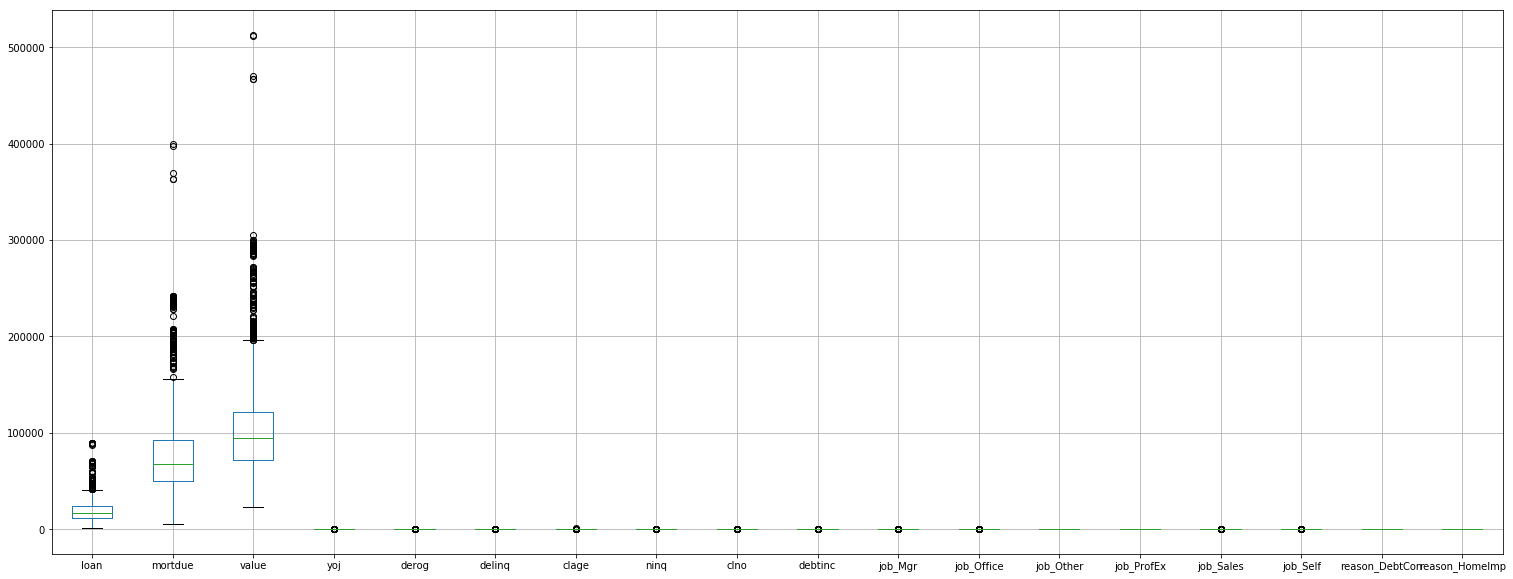

In [103]:
plt.figure(figsize=(26,10))
data_dummy.iloc[:,1:].boxplot()
plt.show()

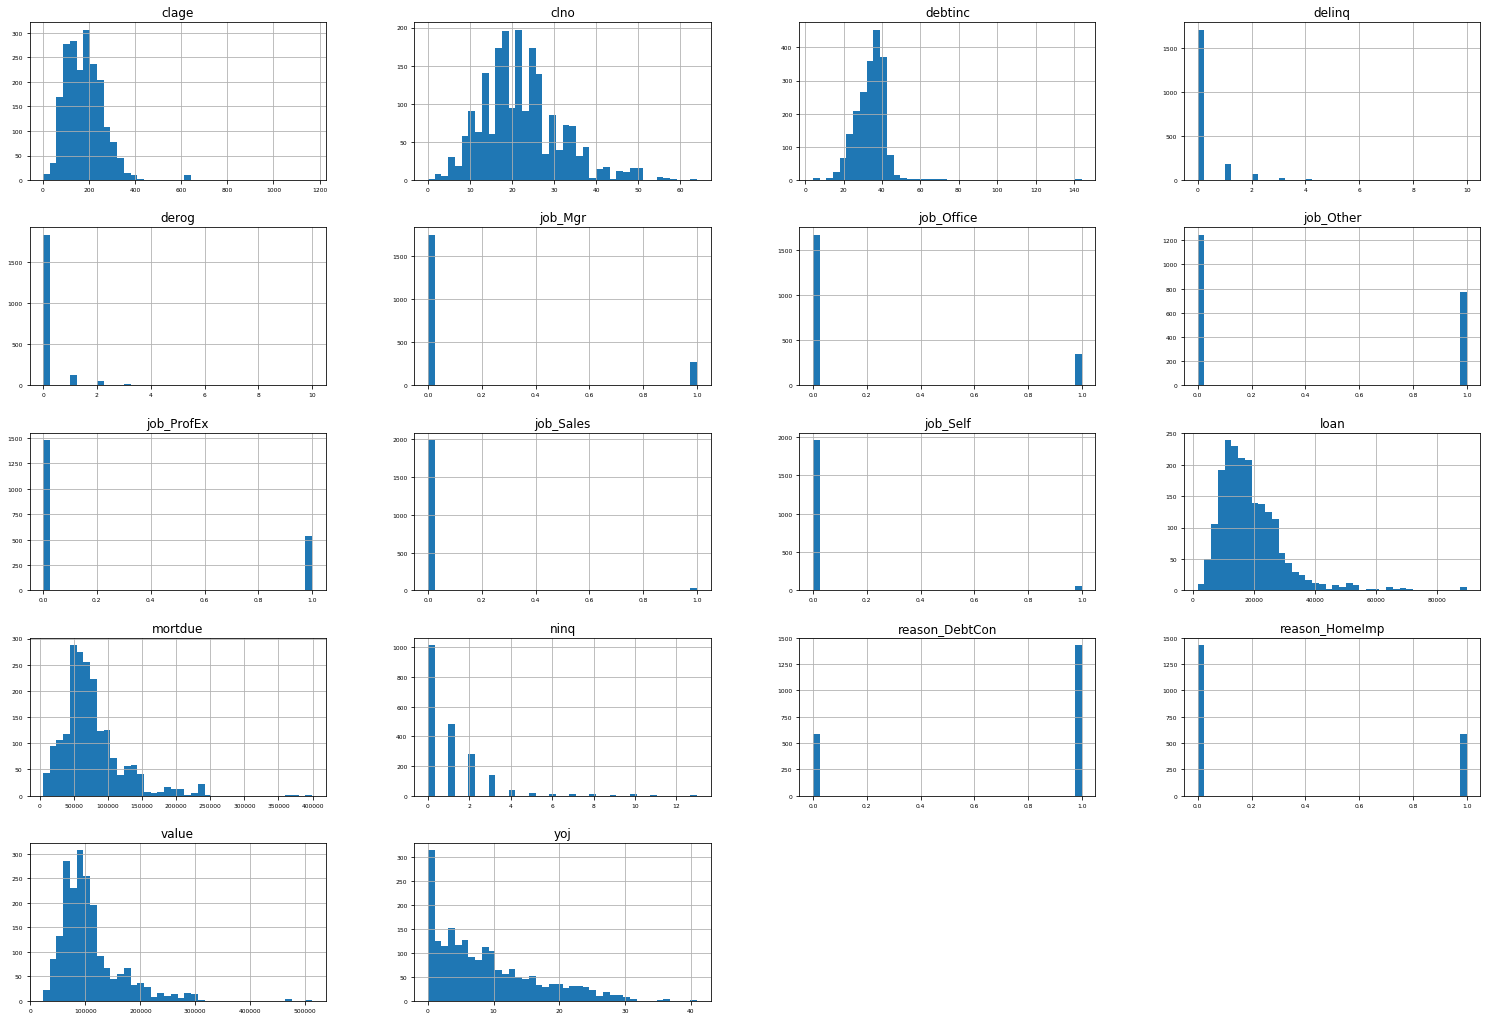

In [104]:
data_df = data_dummy.drop(["bad"], axis=1)
data_df.hist(figsize=(26,18), bins=40, xlabelsize=6, ylabelsize=6)
plt.show()

# 4. Normalization

### 4.1. Min-Max Normalization

In [105]:
scaler = MinMaxScaler()
scaler.fit(data_dummy)
data_minmax = scaler.transform(data_dummy)
data_minmax = pd.DataFrame(data_minmax, columns=data_dummy.columns)
data_minmax.head(3)

,bad,loan,mortdue,value,yoj,derog,delinq,clage,ninq,clno,debtinc,job_Mgr,job_Office,job_Other,job_ProfEx,job_Sales,job_Self,reason_DebtCon,reason_HomeImp
0,0.0,0.187075,0.227347,0.232520,0.365854,0.0,0.0,0.144270,0.153846,0.40625,0.228498,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.226757,0.188073,0.150633,0.121951,0.0,0.0,0.054824,0.461538,0.37500,0.242931,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.367347,0.600643,0.027481,0.024390,0.0,0.2,0.167435,0.230769,0.78125,0.274181,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### 4.2. Standard Scaler

In [106]:
scaler2 = StandardScaler()
scaler2.fit(data_dummy)
data_normalizer = scaler.transform(data_dummy)
data_normalizer = pd.DataFrame(data_normalizer, columns=data_dummy.columns)
data_normalizer.head(3)

,bad,loan,mortdue,value,yoj,derog,delinq,clage,ninq,clno,debtinc,job_Mgr,job_Office,job_Other,job_ProfEx,job_Sales,job_Self,reason_DebtCon,reason_HomeImp
0,0.0,0.187075,0.227347,0.232520,0.365854,0.0,0.0,0.144270,0.153846,0.40625,0.228498,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.226757,0.188073,0.150633,0.121951,0.0,0.0,0.054824,0.461538,0.37500,0.242931,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.367347,0.600643,0.027481,0.024390,0.0,0.2,0.167435,0.230769,0.78125,0.274181,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### 4.3. Quantile Transformer

In [107]:
quantile_transformer = preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
data_quantile = quantile_transformer.fit_transform(data_dummy.drop(["bad"], axis=1))
data_quantile = pd.DataFrame(data_quantile, columns=data_dummy.iloc[:,1:].columns)
data_quantile["bad"] = data_dummy["bad"].values
data_quantile.head()

,loan,mortdue,value,yoj,derog,delinq,clage,ninq,clno,debtinc,job_Mgr,job_Office,job_Other,job_ProfEx,job_Sales,job_Self,reason_DebtCon,reason_HomeImp,bad
0,0.161281,0.721714,0.851335,0.821412,-5.199338,-5.199338,-0.098169,0.875354,0.570161,0.163792,5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,5.199338,-5.199338,0
1,0.503497,0.372812,0.078661,-0.308427,-5.199338,-5.199338,-1.851496,2.023292,0.340163,0.516405,5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,5.199338,-5.199338,0
2,1.513589,2.747473,-2.211979,-1.166919,-5.199338,1.727466,0.244548,1.358913,2.325972,1.555474,5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,5.199338,-5.199338,0
3,-1.371657,-0.143699,-0.512154,-0.687939,-5.199338,1.727466,-0.444878,-5.199338,0.099274,-0.690470,5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,5.199338,0
4,0.072829,-1.468025,-1.793212,0.910873,1.513589,-5.199338,-1.070745,0.309743,-0.513491,-0.940677,5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,5.199338,-5.199338,0


### 4.4. Korelasyon Analizi 

Normalizasyon sonrasi korelasyon analizi incelendi.

In [108]:
data_minmax = data_quantile

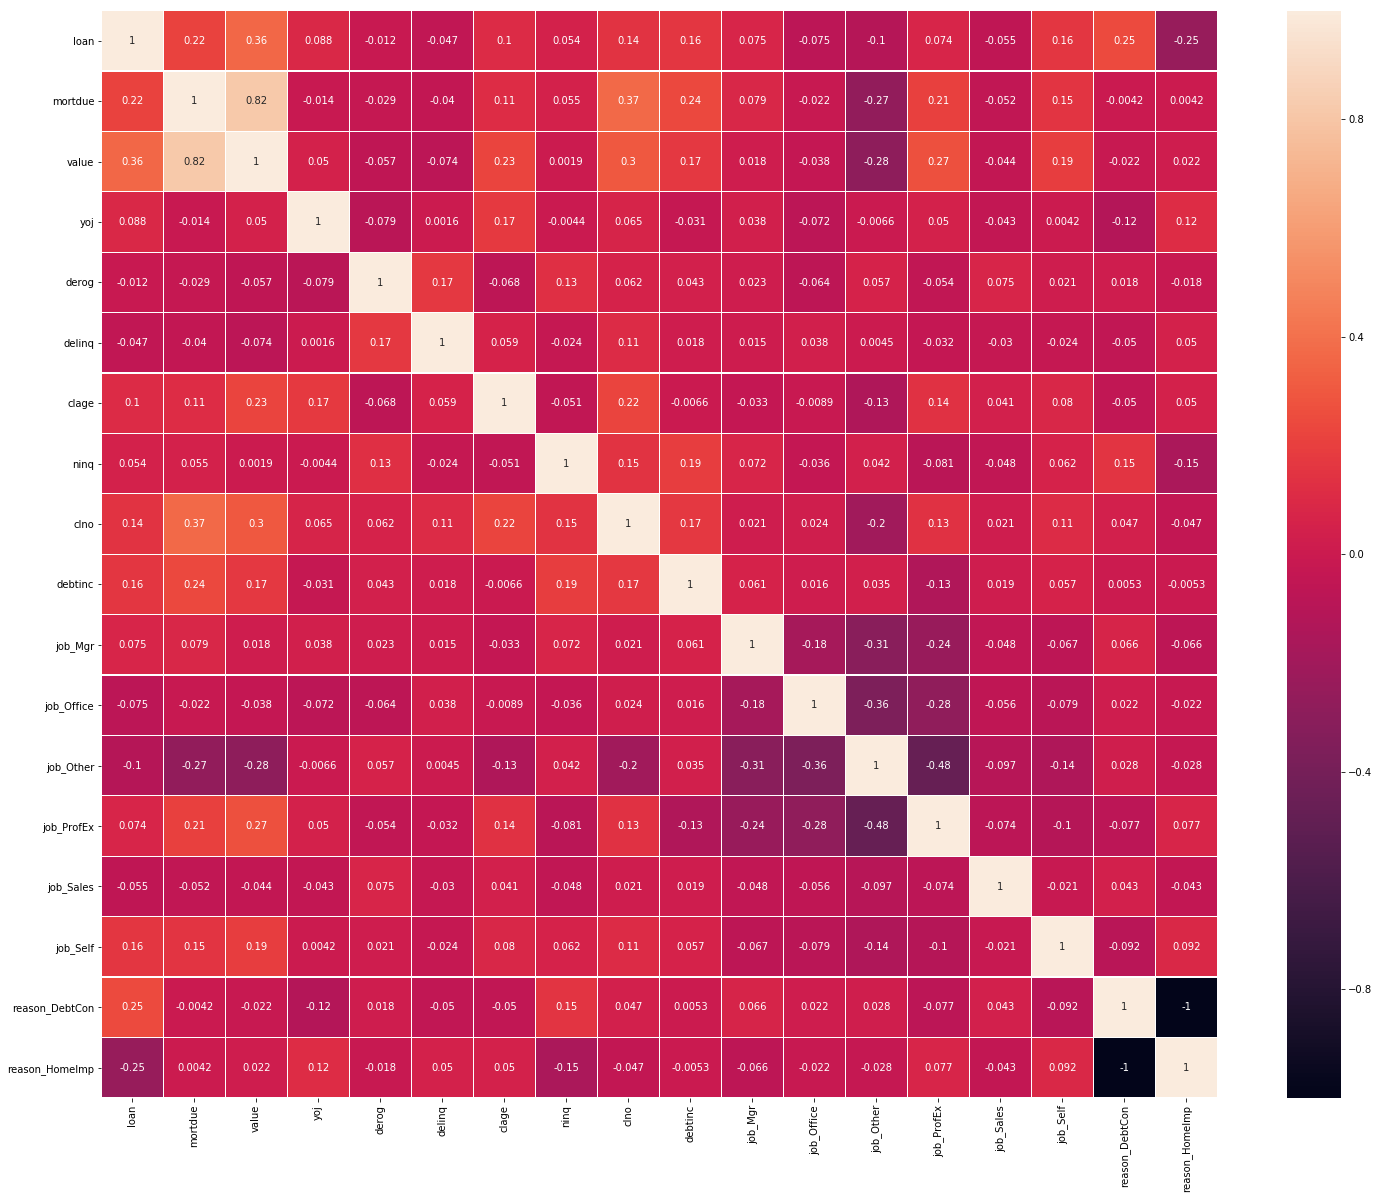

In [109]:
fig, ax = plt.subplots(figsize=(25,20))  
corrmat = data_minmax.drop(["bad"], axis=1)
sns.heatmap(corrmat.corr(), annot=True, linewidths=0.2, ax=ax)
plt.show()

In [110]:
print(correlation_df(data_minmax, ["bad"]).sort_values(by="Corr", ascending=False).head(5),"\n")
print(correlation_df(data_minmax, ["bad"]).sort_values(by="Corr", ascending=True).head(5))

           feature1        feature2      Corr
169  reason_DebtCon  reason_HomeImp  1.000000
19          mortdue           value  0.818718
151       job_Other      job_ProfEx  0.476179
25          mortdue            clno  0.369534
2              loan           value  0.363385 

   feature1        feature2      Corr
53      yoj          delinq  0.001598
40    value            ninq  0.001894
63      yoj        job_Self  0.004173
34  mortdue  reason_HomeImp  0.004216
33  mortdue  reason_DebtCon  0.004216


# 5. Feature Selection 

### 5.1. Correlation based Feature Selection

In [111]:
new_df = layer1(data_minmax,"bad", 0.6)
corrcorr_df = new_df[layer2(new_df, "bad", 7)]
corrcorr_df["bad"] = data_minmax["bad"]
corrcorr_df.head()

,job_ProfEx,loan,job_Sales,clage,derog,delinq,debtinc,bad
0,-5.199338,0.161281,-5.199338,-0.098169,-5.199338,-5.199338,0.163792,0
1,-5.199338,0.503497,-5.199338,-1.851496,-5.199338,-5.199338,0.516405,0
2,-5.199338,1.513589,-5.199338,0.244548,-5.199338,1.727466,1.555474,0
3,-5.199338,-1.371657,-5.199338,-0.444878,-5.199338,1.727466,-0.690470,0
4,-5.199338,0.072829,-5.199338,-1.070745,1.513589,-5.199338,-0.940677,0


### 5.2. PCA based Feature Selection

In [112]:
from sklearn.decomposition import PCA

def pca_fon(X, threshold):
    pca = PCA()
    X_pca = pca.fit_transform(X)
    arr = np.cumsum(np.round(pca.explained_variance_ratio_, decimals = 4)*100)
    num_var = sum((arr < threshold*100)) + 1 
    print('pca sonrası değişken sayısı: ',num_var)
    X_pcad = pd.DataFrame(X_pca[:,0:num_var], index = X.index)
    return X_pcad

pca_reduced_data = pca_fon(data_minmax.drop(["bad"], axis=1), 0.85)
pca_reduced_data["bad"] = data_minmax["bad"]
pca_reduced_data.head()

pca sonrası değişken sayısı:  6


,0,1,2,3,4,5,bad
0,-4.779364,-3.204376,3.386578,9.434912,1.319663,-1.435648,0
1,-4.963109,-3.074993,3.462113,9.551262,2.427075,-1.472590,0
2,-4.834609,-3.139092,3.704792,9.532248,2.024821,5.136299,0
3,10.155385,-0.322301,4.929448,9.377779,-3.624538,5.103674,0
4,-4.850944,-2.737107,3.398660,9.558505,1.520349,1.122113,0


# 6. Logistic Regression 

### 6.1. PCA based Feature Selection

In [113]:
x_pca = pca_reduced_data.drop(["bad"],axis=1)
y_pca = pca_reduced_data["bad"]
xtrain, xtest, ytrain, ytest = train_test_split(x_pca,y_pca, test_size=0.2, random_state=0)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((1614, 6), (404, 6), (1614,), (404,))

In [114]:
from sklearn.linear_model import LogisticRegression
loj1 = LogisticRegression(solver="newton-cg")
loj_model1 = loj1.fit(xtrain, ytrain)
print(loj_model1.intercept_,"\n")
print(loj_model1.coef_)

y_pred = loj_model1.predict(xtrain)
print("\n***** Test Prediction ****\n")
print(confusion_matrix(ytrain, y_pred))

print("\nAccuracy: %.5f\n" % accuracy_score(ytrain, y_pred))

print(classification_report(ytrain,y_pred))

[-2.51583981] 

[[-9.64705012e-03  2.38833615e-02 -1.68400815e-04  3.36348648e-02
   5.30028908e-02  2.16853720e-01]]

***** Test Prediction ****

[[1473    0]
 [ 141    0]]

Accuracy: 0.91264

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1473
           1       0.00      0.00      0.00       141

   micro avg       0.91      0.91      0.91      1614
   macro avg       0.46      0.50      0.48      1614
weighted avg       0.83      0.91      0.87      1614



In [115]:
y_pred = loj_model1.predict(xtest)
print("\n***** Test Prediction ****\n")
print(confusion_matrix(ytest, y_pred))

print("\nAccuracy: %.5f\n" % accuracy_score(ytest, y_pred))

print(classification_report(ytest,y_pred))


***** Test Prediction ****

[[367   0]
 [ 37   0]]

Accuracy: 0.90842

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       367
           1       0.00      0.00      0.00        37

   micro avg       0.91      0.91      0.91       404
   macro avg       0.45      0.50      0.48       404
weighted avg       0.83      0.91      0.86       404



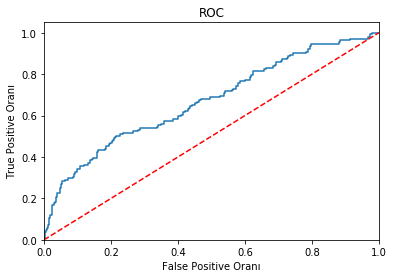

In [116]:
y_pred = [1 if i > 0.5 else 0 for i in loj_model1.predict(xtrain)]

logit_roc_auc = roc_auc_score(ytrain, y_pred)
fpr, tpr, thresholds = roc_curve(ytrain, loj_model1.predict_proba(xtrain)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='AUC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Oranı')
plt.ylabel('True Positive Oranı')
plt.title('ROC')
plt.show()

In [117]:
logit_roc_auc

0.5

### 6.2. Correlation based Feature Selection

In [118]:
x = corrcorr_df.drop(["bad"],axis=1)
y = corrcorr_df["bad"]
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.2, random_state=0)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

from sklearn.linear_model import LogisticRegression
loj = LogisticRegression(solver="liblinear")
loj_model = loj.fit(xtrain,ytrain)
print(loj_model1.intercept_,"\n")
print(loj_model1.coef_)

y_pred = loj_model.predict(xtrain)
print("\n***** Test Prediction ****\n")
print(confusion_matrix(ytrain, y_pred))

print("\nAccuracy: %.5f\n" % accuracy_score(ytrain, y_pred))

print(classification_report(ytrain,y_pred))

[-2.51583981] 

[[-9.64705012e-03  2.38833615e-02 -1.68400815e-04  3.36348648e-02
   5.30028908e-02  2.16853720e-01]]

***** Test Prediction ****

[[1469    4]
 [ 125   16]]

Accuracy: 0.92007

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1473
           1       0.80      0.11      0.20       141

   micro avg       0.92      0.92      0.92      1614
   macro avg       0.86      0.56      0.58      1614
weighted avg       0.91      0.92      0.89      1614



In [119]:
y_pred = loj_model.predict(xtest)

print("\n***** Test Prediction ****\n")
print(confusion_matrix(ytest, y_pred))

print("\nAccuracy: %.5f\n" % accuracy_score(ytest, y_pred))

print(classification_report(ytest,y_pred))


***** Test Prediction ****

[[367   0]
 [ 32   5]]

Accuracy: 0.92079

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       367
           1       1.00      0.14      0.24        37

   micro avg       0.92      0.92      0.92       404
   macro avg       0.96      0.57      0.60       404
weighted avg       0.93      0.92      0.89       404



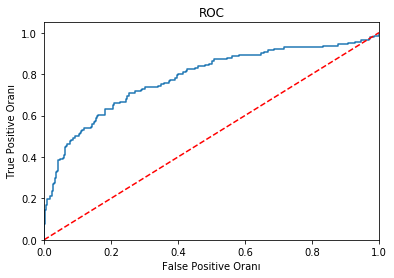

In [120]:
y_pred = [1 if i > 0.5 else 0 for i in loj_model.predict(xtrain)]

logit_roc_auc = roc_auc_score(ytrain, y_pred)
fpr, tpr, thresholds = roc_curve(ytrain, loj_model.predict_proba(xtrain)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='AUC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Oranı')
plt.ylabel('True Positive Oranı')
plt.title('ROC')
plt.show()